In [22]:
#!pip install gym
#!pip install torch
#!pip install causalinference
#!pip install moviepy
#!pip install pygame
#!pip install gym[classic_control]
#!pip install torchviz

In [23]:
import os
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from causalinference import CausalModel

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api  as smf
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import islice
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy import stats

from IPython.display import display
from IPython import display
from IPython.display import Image

from torchviz import make_dot

In [24]:
class ReplayMemory(object):
    Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward')) 
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)        
    
    def push(self, state, action, next_state, reward, episode_dur):  
        self.memory.append((self.Transition(state,action,next_state,reward),episode_dur))              

    def sample(self,batch_size):            
        indices_muestreo = np.random.choice(len(self.memory), batch_size)
        transiciones_muestreadas = [self.memory[i][0] for i in indices_muestreo]
        return transiciones_muestreadas

    def __len__(self):
        return len(self.memory)    

In [25]:
class DQN(nn.Module):
   
    l2_lambda=0.01
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 8)
        #self.dropout1 = nn.Dropout(p=0.3)
        self.layer2 = nn.Linear(8, 8)
        self.layer3 = nn.Linear(8, n_actions)

    #def l2_regularization_loss(self):
    #    l2_loss = 0
    #    for param in self.parameters():
    #        l2_loss += torch.norm(param, p=2)  # Calcula la norma L2 de los parámetros
    #    return self.l2_lambda * l2_loss
    
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        #x = self.dropout1(x)
        x = F.relu(self.layer2(x))
        return self.layer3(x)


In [26]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

class Agente():
    # BATCH_SIZE is the number of transitions sampled from the replay buffer
    # GAMMA is the discount factor as mentioned in the previous section
    # EPS_START is the starting value of epsilon
    # EPS_END is the final value of epsilon
    # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
    # TAU is the update rate of the target network
    # LR is the learning rate of the ``AdamW`` optimizer
    BATCH_SIZE = 8
    GAMMA = 0.99
    EPS_START = 0.9
    EPS_END = 0.05
    EPS_DECAY = 1000
    TAU = 0.005
    LR = 1e-4
    Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))    
    loss_history = []
    num_episodes = 0


    def __init__(self,device,env):
        self.device = device
        self.env = env    
        # Get number of actions from gym action space
        n_actions = env.action_space.n
        # Get the number of state observations
        state, info = env.reset()
        n_observations = len(state)

        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
        self.memory = ReplayMemory(10000)

        self.steps_done = 0
        self.episode_durations = []
        self.video_path = "./recorder.mp4"
        self.video_recorder = VideoRecorder(env, self.video_path, enabled=self.video_path is not None)
        
        self.metricas_eval =[]
        self.loss = 0.0
        self.entropy_pol = 0.0
        self.paso_episodio = 0.0
        self.exploracion = 0.0
        self.explotacion = 0.0
        
    
    def save(self,file=''):
         torch.save({'model_state_dict': self.policy_net.state_dict(),
                     'optimizer_state_dict' : self.optimizer.state_dict(),}, 
                    file)

    def load(self,file='',modo='train'):        
        if os.path.isfile(file):            
            print("=> loading checkpoint... ")
            self.policy_net = DQN(n_observations, n_actions).to(device)
            self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)            
            checkpoint = torch.load(file)
            self.policy_net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  
            if modo != 'train':
                self.policy_net.eval()
            else:
                self.policy_net.train()
            print("done !")
        else:
            print("no checkpoint found...")

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        self.paso_episodio +=1
        if sample > eps_threshold:
            self.explotacion+=1
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            self.exploracion+=1
            return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)    


    def optimize_model(self):        
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        
        
        #measuring entropy of policy_net
        self.entropy_pol = -sum((1/self.steps_done) * np.log(1/self.steps_done) for _ in range(self.steps_done))
                       
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = self.Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.BATCH_SIZE, device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        #l2_loss = self.policy_net.l2_regularization_loss()
        #loss += l2_loss
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        # Registrar el valor de la pérdida en el historial
        self.loss_history.append(loss.item())
        self.loss += loss.item()        
        
    def graficar_aprendizaje(self):
        # Graficar el historial de pérdidas
        plt.plot(self.loss_history)        
        plt.xlabel('Episodio')
        plt.ylabel('Pérdida')       
        plt.ylim(0,1)
        plt.title('Progreso de la Pérdida durante el Entrenamiento')        
        plt.show()   

    def plot_durations1(self):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        plt.title('Result')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        means = durations_t.unfold(0, self.num_episodes, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(self.num_episodes-1), means))
        plt.plot(means.numpy())
        
    def plot_durations(self):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        plt.title('Result')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy(),marker='o', label='Duraciones')
        means = np.mean(durations_t.numpy())
        plt.axhline(y=means, color='r', linestyle='--', label='Promedio')

    def entrenar(self):
        if torch.cuda.is_available():
            self.num_episodes = 600
        else:
            self.num_episodes = 200
        
        loss = 0.0
        for i_episode in range(self.num_episodes):
            print("Episodio: {}".format(i_episode))
            # Initialize the environment and get it's state
            state, info = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            duracion = 0.0
            sum_rewards = 0.0
            record = []
            self.loss = 0.0
            self.exploracion = 0.0
            self.explotacion = 0.0
            self.paso_episodio = 0
            for t in count():
                self.env.render()
                
                self.video_recorder.capture_frame()
                
                action = self.select_action(state)
                observation, reward, terminated, truncated, _ = self.env.step(action.item())
                reward = torch.tensor([reward], device=self.device)
                done = terminated or truncated
                
                sum_rewards += reward.item()
                
                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)

                # Store the transition in memory
                self.memory.push(state, action, next_state, reward,duracion)
                #duracion += torch.tensor(self.episode_durations, dtype=torch.float).numpy()
                #self.memory.save(t)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                self.optimize_model()

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
                self.target_net.load_state_dict(target_net_state_dict)

                if done:
                    self.episode_durations.append(t + 1) 
                    duracion += 1                    
                    break
                    
            record.append([i_episode,sum_rewards,self.loss,self.entropy_pol,self.paso_episodio,self.exploracion,(self.exploracion/sum_rewards),self.explotacion,(self.explotacion/sum_rewards)])
            self.metricas_eval.append(record)
        
        print('Complete')
        self.video_recorder.close()
        self.video_recorder.enabled = False
        self.save('./ckpt.pth')
        self.env.close()   
        
        
        
        metricas = np.array(self.metricas_eval)
        flattened_data = metricas.reshape(-1, 9).tolist()
        df_metricas = pd.DataFrame(flattened_data,columns=['Episode','sum_rewwards','loss','entropy','paso_episodio','c_exploracion','p_exploracion','c_explotacion','p_explotacion'])
        duracion = torch.tensor(self.episode_durations, dtype=torch.float).numpy()
       
        df_metricas['duration'] = duracion.tolist()
        df_metricas.to_csv('./metricas_RS.csv',index=False)
        

        
        
    def visualize_architecture(self):
        model = self.policy_net  # Reemplaza "YourModel" con tu propia definición de modelo
        x = torch.randn(1, 4)  # Crea una entrada de ejemplo para el modelo

        # Genera el gráfico del modelo
        y = model(x)
        dot = make_dot(y, params=dict(model.named_parameters()))

        # Guarda el gráfico como una imagen o muestra en pantalla
        dot.render("model_graph", format="png")  # Guarda 
        Image("model_graph.png")
            

In [27]:
def Main():
    env = gym.make("CartPole-v1",render_mode='rgb_array')    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    agente = Agente(device,env)
    #agente.visualize_architecture()
    agente.entrenar()
    agente.graficar_aprendizaje()
    agente.plot_durations()

Episodio: 0


C:\Users\JVelez\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episodio: 1
Episodio: 2
Episodio: 3
Episodio: 4
Episodio: 5
Episodio: 6
Episodio: 7
Episodio: 8
Episodio: 9
Episodio: 10
Episodio: 11
Episodio: 12
Episodio: 13
Episodio: 14
Episodio: 15
Episodio: 16
Episodio: 17
Episodio: 18
Episodio: 19
Episodio: 20
Episodio: 21
Episodio: 22
Episodio: 23
Episodio: 24
Episodio: 25
Episodio: 26
Episodio: 27
Episodio: 28
Episodio: 29
Episodio: 30
Episodio: 31
Episodio: 32
Episodio: 33
Episodio: 34
Episodio: 35
Episodio: 36
Episodio: 37
Episodio: 38
Episodio: 39
Episodio: 40
Episodio: 41
Episodio: 42
Episodio: 43
Episodio: 44
Episodio: 45
Episodio: 46
Episodio: 47
Episodio: 48
Episodio: 49
Episodio: 50
Episodio: 51
Episodio: 52
Episodio: 53
Episodio: 54
Episodio: 55
Episodio: 56
Episodio: 57
Episodio: 58
Episodio: 59
Episodio: 60
Episodio: 61
Episodio: 62
Episodio: 63
Episodio: 64
Episodio: 65
Episodio: 66
Episodio: 67
Episodio: 68
Episodio: 69
Episodio: 70
Episodio: 71
Episodio: 72
Episodio: 73
Episodio: 74
Episodio: 75
Episodio: 76
Episodio: 77
Episodio

Moviepy - Done !
Moviepy - video ready ./recorder.mp4


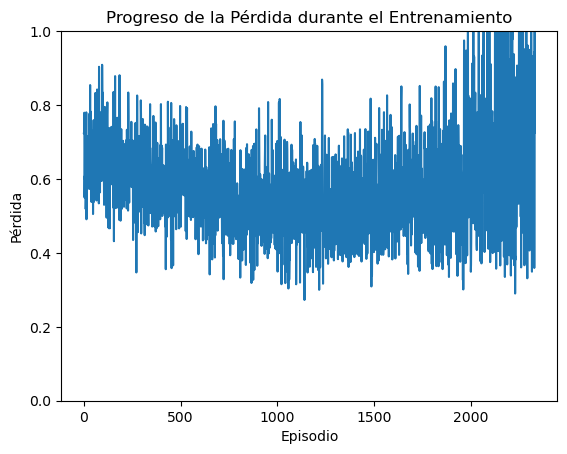

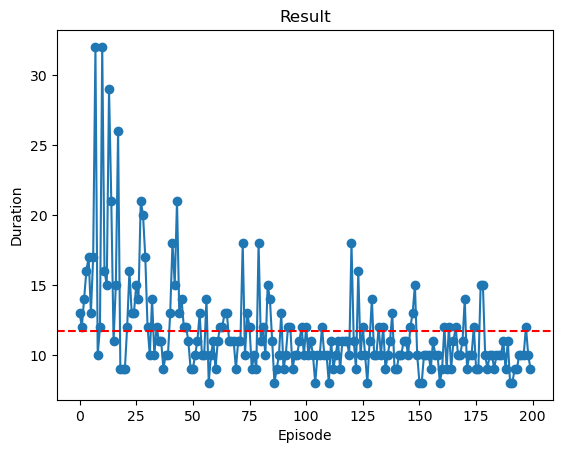

In [28]:
Main()